<a href="https://colab.research.google.com/github/gormantt/foursquare-location-matching/blob/main/Ling_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis

---
Data analyzed in this notebook is from [Kaggle's code competation: Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching/data). The data comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe. The task is to **determine which place entries describe the same point-of-interest**. Though the data entries may represent or resemble entries for real places, they may also contain artificial information or additional noise.


In [137]:
import pandas as pd
import numpy as np
import seaborn as sns

#For plotting
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

lreg = LogisticRegression()

We read the data below and take a look at some columns.

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
pairs = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/pairs.csv')
test = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/train.csv')

# Training data

---

## The data


*   `train.csv` - The training set, comprising eleven attribute fields for over one million place entries, together with:
  * `id` - A unique identifier for each entry.
  * `point_of_interest` - An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries "match" when they describe a common POI. 
*   `pairs.csv` - A pregenerated set of pairs of place entries from `train.csv` designed to improve detection of matches.
  * `match` - Whether (`True` or `False`) the pair of entries describes a common POI.



In [140]:
print('There are', len(set(train.id)), 'id, and', len(set(train.point_of_interest)), 'distinct POIs.\n')
print('About', np.round(len(set(train.point_of_interest))/len(set(train.id))*100,2),'% POIs are unique.\n')

There are 1138812 id, and 739972 distinct POIs.

About 64.98 % POIs are unique.



In [141]:
train.sample(5)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
276067,E_3df85b4877fbc2,Departure Platform At Jb Castam,1.464381,103.766303,Jb castam,NaN,NaN,NaN,MY,NaN,NaN,NaN,P_a7829bfa2c8bc6
607590,E_8890ce3d821d55,Gelibolu Yarımadası,40.148943,26.378255,Gelibolu Yarımadası,Canakkale,Turkiye,NaN,TR,NaN,NaN,"Other Great Outdoors, Historic Sites",P_342498539b6c87
920646,E_cecd328af46ca9,Four Points by Sheraton Jakarta,-6.188392,106.822830,Menara Topas,Jakarta Pusat,DKI Jakarta,NaN,ID,NaN,NaN,Hotels,P_b66cd78d41ba91
946704,E_d4a4cdf0a03c2d,Билайн - Домашний интернет и ТВ,55.343985,86.063998,"пр. Ленина, д. 3",Кемерово,Кемеровская обл.,650000,RU,https://mirbeeline.ru/kemerovo,8007000611,Mobile Phone Shops,P_dfbcfc6199776f
1084593,E_f3b8be3a5b20ec,WTC Mangga Dua,-6.133441,106.830885,Jl. Mangga Dua Raya No. 8,Jakarta Utara,DKI Jakarta,14430,ID,NaN,2130018888,"Shopping Malls, Convenience Stores",P_4ba5cdd1d72d25


In [142]:
print('There are', len(pairs), 'pairs,', len(set(pairs.id_1)), 'id_1s and', len(set(pairs.id_2)), 'id_2s.\n')

There are 578907 pairs, 464765 id_1s and 565512 id_2s.



In [143]:
pairs.loc[0]

id_1                E_000001272c6c5d
name_1          Café Stad Oudenaarde
latitude_1                 50.859975
longitude_1                 3.634196
address_1                Abdijstraat
city_1                    Nederename
state_1              Oost-Vlaanderen
zip_1                           9700
country_1                         BE
url_1                            NaN
phone_1                          NaN
categories_1                    Bars
id_2                E_da7fa3963561f8
name_2               Café Oudenaarde
latitude_2                 50.869358
longitude_2                 3.635206
address_2                        NaN
city_2                           NaN
state_2                          NaN
zip_2                            NaN
country_2                         BE
url_2                            NaN
phone_2                          NaN
categories_2                    Bars
match                           True
Name: 0, dtype: object

## Considering only US locations

In [144]:
train_US = train.loc[train.country=='US']
pairs = pairs.loc[(pairs.country_1=='US') & (pairs.country_2=='US')]

In [145]:
print("{:.2%}".format(len(train_US)/len(train)),'locations are in US')
print("{:.2%}".format(len(pairs_US)/len(pairs)),'pairs are in US')

21.54% locations are in US
100.00% pairs are in US


## Missing values




In [146]:
for col in train.columns:
    print('In train.csv,',"{:.6%}".format(1-len(train[col].dropna())/len(train[col])), 'rows have "NaN" for', col)

In train.csv, 0.000000% rows have "NaN" for id
In train.csv, 0.000088% rows have "NaN" for name
In train.csv, 0.000000% rows have "NaN" for latitude
In train.csv, 0.000000% rows have "NaN" for longitude
In train.csv, 34.827610% rows have "NaN" for address
In train.csv, 26.272027% rows have "NaN" for city
In train.csv, 36.931996% rows have "NaN" for state
In train.csv, 52.284837% rows have "NaN" for zip
In train.csv, 0.000966% rows have "NaN" for country
In train.csv, 76.490940% rows have "NaN" for url
In train.csv, 69.893626% rows have "NaN" for phone
In train.csv, 8.632417% rows have "NaN" for categories
In train.csv, 0.000000% rows have "NaN" for point_of_interest


In [147]:
for col in train_US.columns:
    print('In train_US.csv,',"{:.6%}".format(1-len(train_US[col].dropna())/len(train_US[col])), 'rows have "NaN" for', col)

In train_US.csv, 0.000000% rows have "NaN" for id
In train_US.csv, 0.000408% rows have "NaN" for name
In train_US.csv, 0.000000% rows have "NaN" for latitude
In train_US.csv, 0.000000% rows have "NaN" for longitude
In train_US.csv, 23.018216% rows have "NaN" for address
In train_US.csv, 3.686747% rows have "NaN" for city
In train_US.csv, 2.409860% rows have "NaN" for state
In train_US.csv, 13.048955% rows have "NaN" for zip
In train_US.csv, 0.000000% rows have "NaN" for country
In train_US.csv, 59.444155% rows have "NaN" for url
In train_US.csv, 46.349130% rows have "NaN" for phone
In train_US.csv, 5.361540% rows have "NaN" for categories
In train_US.csv, 0.000000% rows have "NaN" for point_of_interest


## Generate more pairs



In [148]:
len(set(list(pairs.id_1)+list(pairs.id_2)))

219240

In [149]:
len(set(train.id)-set(list(pairs.id_1)+list(pairs.id_2)))

919572

# Features

---

The features available in `test.csv` include 

```
'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'
```


In [151]:
from sklearn.feature_extraction.text import CountVectorizer

coun_vect=CountVectorizer()

def countvec_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        count_matrix=coun_vect.fit_transform([a,b])
    return np.count_nonzero(count_matrix.toarray()[0]!=count_matrix.toarray()[1])/len(count_matrix.toarray()[0])

In [152]:
pairs['name_coun_vect_diff'] = pairs.apply(countvec_metric,
                          args=('name_1', 'name_2'),
                          axis=1)

ValueError: ignored

## Latitude and longitude


---
We compute the difference for (latitude, longitude) of each pair in `pairs.csv`. It turns out 
  * locations with close (difference less than 0.001) can have have different POIs: stores are next to each other in a shopping center. In some extreme cases, places with identical coordinates can have different POI. For example, one classroom can be located vertically on top of another.  
  * conversely, locations physically far can represent the same POI, such as mountains.

In [154]:
#pairs['latitude_diff'] = (pairs['latitude_1']-pairs['latitude_2']).abs()
#pairs['longitude_diff'] = (pairs['longitude_1']-pairs['longitude_2']).abs()
#pairs['location_diff'] = pairs['latitude_1']-pairs['latitude_2']

# Compute the difference of (latitude, longitude) of each pair in pairs.csv
pairs['location_diff'] = pd.concat([(pairs['latitude_1']-pairs['latitude_2']).abs(), (pairs['longitude_1']-pairs['longitude_2']).abs()], axis=1).max(axis=1)

print(pairs.location_diff, '\nThe largest difference is', pairs.location_diff.max(),'\nThe average difference is', pairs.location_diff.mean())

3         0.000141
6         0.005068
7         0.001011
8         0.014307
11        0.006102
            ...   
578885    0.038925
578888    0.001929
578890    0.000119
578900    0.100096
578904    0.008220
Name: location_diff, Length: 117708, dtype: float64 
The largest difference is 222.460965008789 
The average difference is 0.08730819055571455


In [155]:
pairs.country_1.value_counts()

US    117708
Name: country_1, dtype: int64

In [156]:
len(pairs.loc[(pairs.country_1=='NZ') & (pairs.location_diff<0.001)])

0

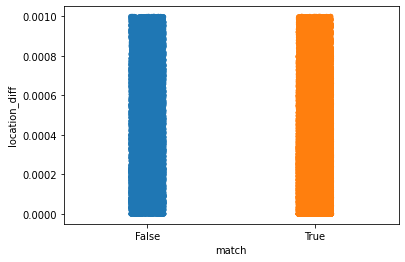

In [159]:
sns.stripplot(x="match", y="location_diff", data=pairs.loc[pairs.location_diff<0.001])
plt.show()

In [160]:
print('There are',len(pairs.loc[(pairs.location_diff==0) & (pairs.match==False)]),'pairs with location_diff=0 but different POIs, out of all',len(pairs),'pairs.')

There are 146 pairs with location_diff=0 but different POIs, out of all 117708 pairs.


In [283]:
pairs.columns

Index(['id_1', 'name_1', 'latitude_1', 'longitude_1', 'address_1', 'city_1',
       'state_1', 'zip_1', 'country_1', 'url_1', 'phone_1', 'categories_1',
       'id_2', 'name_2', 'latitude_2', 'longitude_2', 'address_2', 'city_2',
       'state_2', 'zip_2', 'country_2', 'url_2', 'phone_2', 'categories_2',
       'match', 'location_diff', 'name_diff', 'address_diff', 'city_diff',
       'zip_diff', 'state_diff', 'country_diff', 'url_diff', 'phone_diff',
       'categories_diff'],
      dtype='object')

## Comparing strings

Most columns in this data are strings. We consider different metrics for string comparison.

In [284]:
def compute_diffs(df, cols, string_metric):
    df_copy = df
    for col in cols:
        df_copy[col+'_diff'] = df.apply(string_metric,
                          args=(col+'_1', col+'_2'),
                          axis=1)
    return df_copy[ ['id_1','id_2','match']+['location_diff']+ [col+'_diff' for col in cols] ]

# SequenceMatcher

In [285]:
from difflib import SequenceMatcher
import math
# Reference: https://stackoverflow.com/questions/43916271/python-pandas-sequencematch-columns-for-each-value-and-return-closet-match

def seq_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
        
    return 1-SequenceMatcher(None, a, b).ratio()

In [286]:
columns = ['name', 'address', 'city', #'state',
       'zip', 'url', 'phone', 'categories']
       
pairs_seq = compute_diffs(pairs, columns, seq_metric)

### Histogram

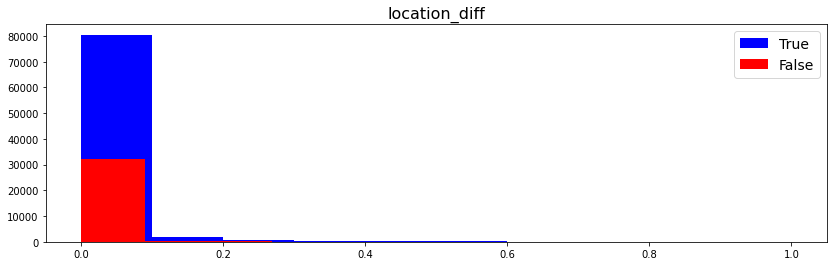

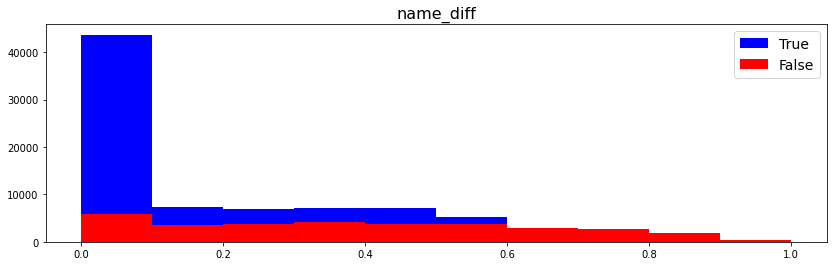

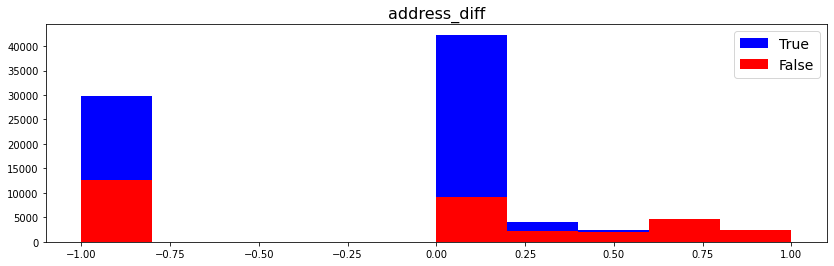

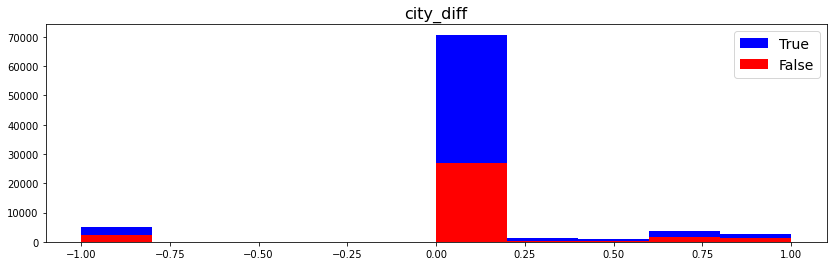

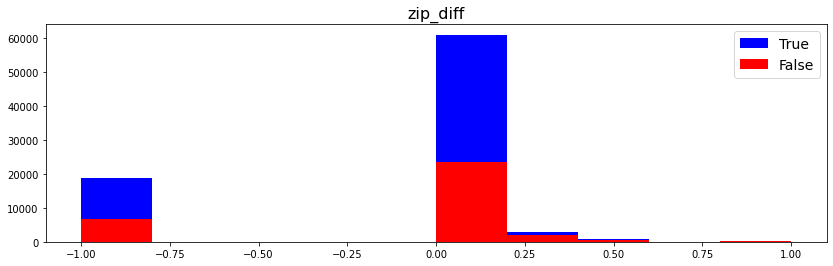

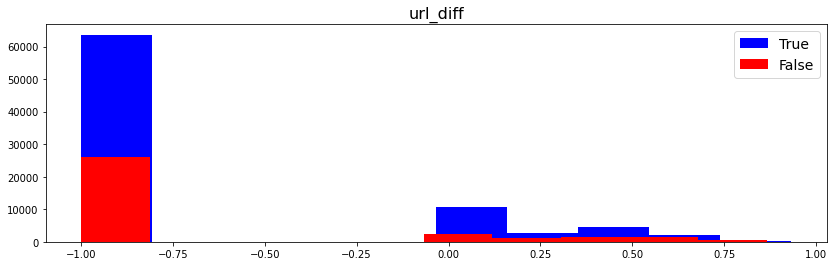

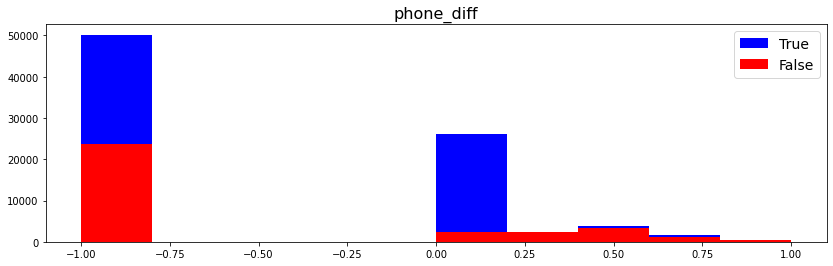

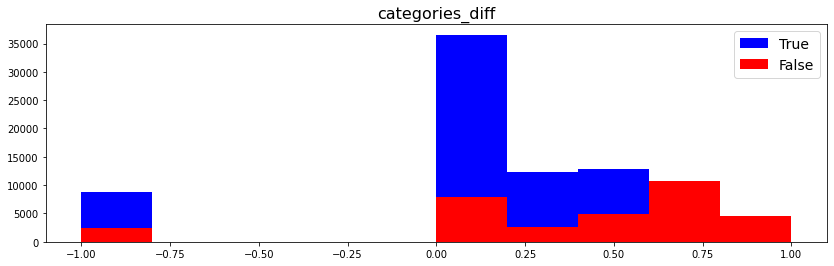

In [287]:
## histograms
for column in ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']:
    plt.figure(figsize=(14,4))
    plt.hist(pairs_seq.loc[(pairs_seq.match==True)&(pairs_seq.location_diff<1), column], color='b', label="True")
    plt.hist(pairs_seq.loc[(pairs_seq.match==False)&(pairs_seq.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

## Logistic regression

In [288]:
cols = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

columns = [ cols[1:i+2] for i in range(len(cols)-1)]

scores=[]

for cols in columns:
    pairs_copy=pairs_seq[['match']+cols]

    train,test=train_test_split(pairs_copy, test_size=.2, random_state=0)

    X_train = train[cols]
    X_test = test[cols]

    y_train = train['match']
    y_test = test['match']

    lreg = LogisticRegression()
    lreg.fit(X_train,y_train)

    y_pred = lreg.predict(X_test)

    confusion_matrix(y_test,y_pred)
    scores.append(roc_auc_score(y_test,y_pred))

print(scores)

[0.5829470534457306, 0.5941154061908662, 0.5944947963348373, 0.5959446320062841, 0.5957718894181423, 0.5944024930140148, 0.6302253379825387]


In [289]:
print('The percentage of true matches is',"{:.2%}".format(pairs.match.value_counts()[1]/len(pairs)))

The percentage of true matches is 71.88%


# Levenshtein distance

In [ ]:
!pip install python-Levenshtein

In [291]:
from Levenshtein import distance as lev
def lev_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
    #if a in b or b in a: 
    #    return 0
    return lev(a,b)/max(len(a),len(b))

In [292]:
columns = ['name', 'address', 'city', 'state', 'zip', 'url', 'phone', 'categories']
       
pairs_lev = compute_diffs(pairs, columns, lev_metric)

### Histogram

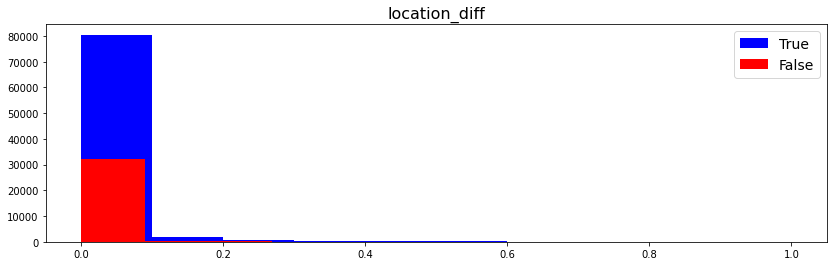

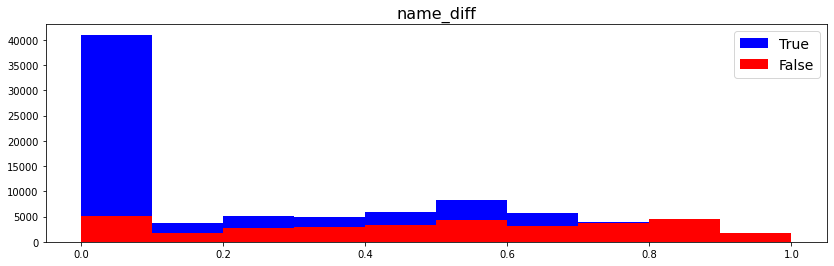

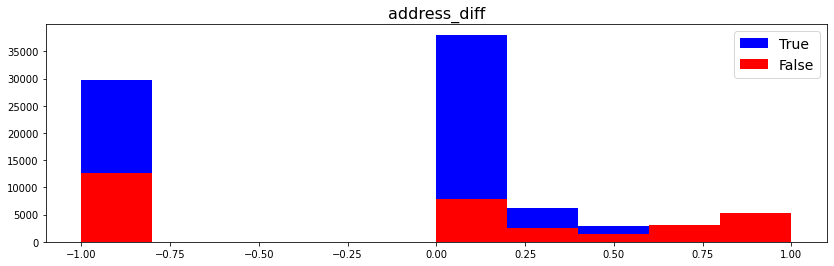

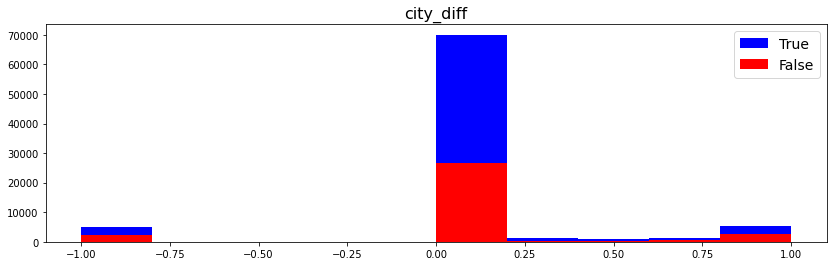

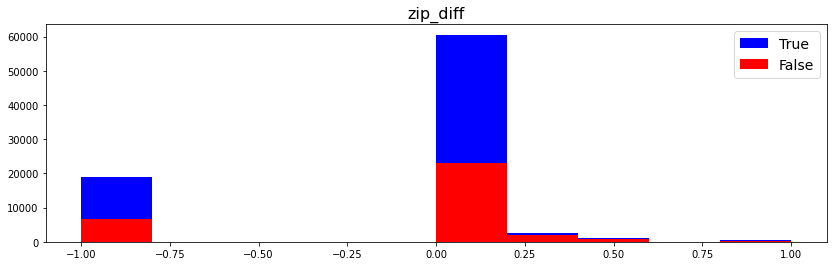

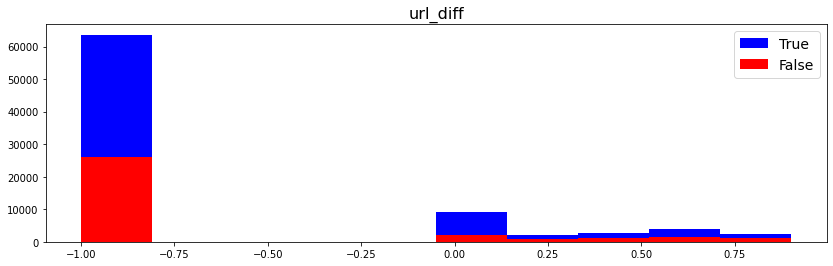

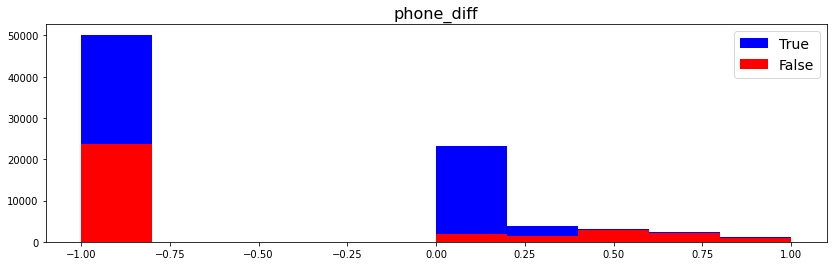

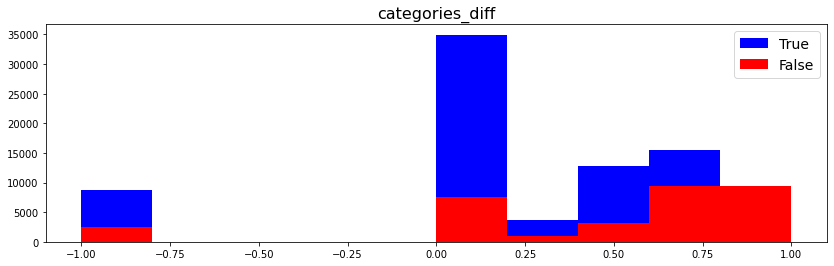

In [293]:
## histograms
for column in ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']:
    plt.figure(figsize=(14,4))
    plt.hist(pairs_lev.loc[(pairs_lev.match==True)&(pairs_lev.location_diff<1), column], color='b', label="True")
    plt.hist(pairs_lev.loc[(pairs_lev.match==False)&(pairs_lev.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

In [294]:
cols = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']
cols[:len(cols)]

['location_diff',
 'name_diff',
 'address_diff',
 'city_diff',
 'zip_diff',
 'url_diff',
 'phone_diff',
 'categories_diff']

## Logistic regression

In [338]:
cols = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

columns = [ cols[1:i+2] for i in range(len(cols)-1)]

scores=[]
for cols in columns:
    pairs_copy=pairs_lev[['match']+cols]

    train,test=train_test_split(pairs_copy, test_size=.2, random_state=0)

    X_train = train[cols]
    X_test = test[cols]

    y_train = train['match']
    y_test = test['match']

    lreg = LogisticRegression(C=1)
    lreg.fit(X_train,y_train)

    y_pred = lreg.predict(X_test)

    confusion_matrix(y_test,y_pred)
    scores.append(roc_auc_score(y_test,y_pred))

print(scores)

[0.5726763186089913, 0.591725486370476, 0.5925178315023532, 0.5947179712198201, 0.5947771348513969, 0.588388111561414, 0.6270264606701792]


## Threshoding location_diff

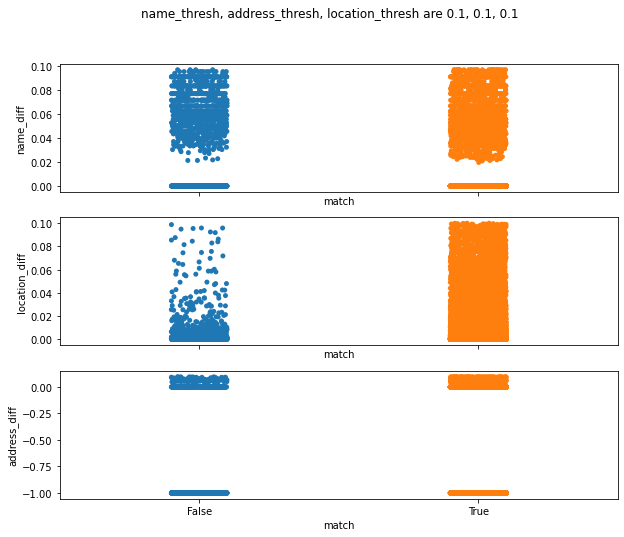

(True     0.951418
 False    0.048582
 Name: match, dtype: float64, 0.26056002990450944)

In [346]:
name_thresh, address_thresh, location_thresh = 0.1,0.1,0.1
cols = ['name_diff','location_diff', 'address_diff']

df = pairs_lev.loc[(pairs_lev.name_diff<name_thresh)&(pairs_lev.address_diff<address_thresh)&(pairs_lev.location_diff<location_thresh)]

fig,ax = plt.subplots(3,1, figsize=(10,8), sharex=True)

fig.suptitle('name_thresh, address_thresh, location_thresh are 0.1, 0.1, 0.1')

for i in range(len(cols)):
    sns.stripplot(x="match", y=cols[i], data=df, ax=ax[i])

plt.show()

df.match.value_counts()/len(df), len(df)/len(pairs_lev)

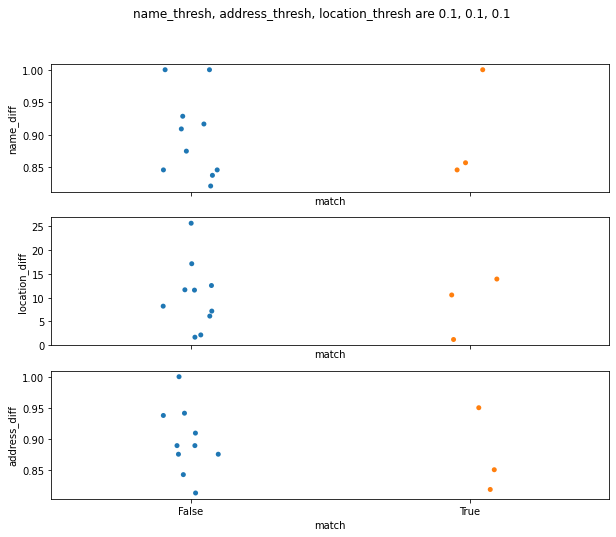

False    0.769231
True     0.230769
Name: match, dtype: float64

In [343]:
name_thresh, address_thresh, location_thresh = 0.8,0.8,0.8
cols = ['name_diff','location_diff', 'address_diff']

df = pairs_lev.loc[(pairs_lev.name_diff>name_thresh)&(pairs_lev.address_diff>address_thresh)&(pairs_lev.location_diff>location_thresh)]

fig,ax = plt.subplots(3,1, figsize=(10,8), sharex=True)

fig.suptitle('name_thresh, address_thresh, location_thresh are 0.1, 0.1, 0.1')

for i in range(len(cols)):
    sns.stripplot(x="match", y=cols[i], data=df, ax=ax[i])

plt.show()

df.match.value_counts()/len(df)

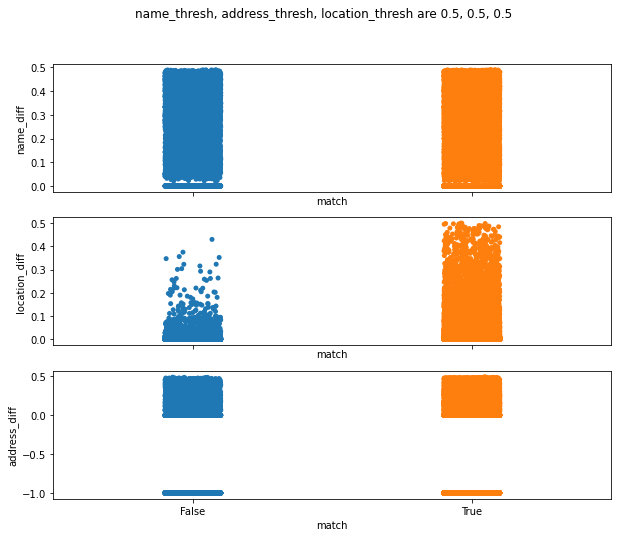

True     0.832563
False    0.167437
Name: match, dtype: float64

In [337]:
name_thresh, address_thresh, location_thresh = 0.5, 0.5, 0.5
cols = ['name_diff','location_diff', 'address_diff']

df = pairs_lev.loc[(pairs_lev.name_diff<name_thresh)&(pairs_lev.address_diff<address_thresh)&(pairs_lev.location_diff<location_thresh)]

fig,ax = plt.subplots(3,1, figsize=(10,8), sharex=True)

fig.suptitle('name_thresh, address_thresh, location_thresh are 0.5, 0.5, 0.5')

for i in range(len(cols)):
    sns.stripplot(x="match", y=cols[i], data=df, ax=ax[i])

plt.show()

df.match.value_counts()/len(df)

True     0.832563
False    0.167437
Name: match, dtype: float64

In [300]:
pairs.loc[pairs.id_1=='E_00efc97ecd2a98'].values

array([['E_00efc97ecd2a98', 'Greek From Greece', 40.75195022641434,
        -73.99019108026202, nan, 'New York', 'NY', '10018', 'US', nan,
        nan, 'Greek Restaurants', 'E_b213a99b54954a',
        'Greek From Greece', 40.759575, -73.989365, '45 W 45th St',
        'New York', 'NY', '10036', 'US', nan, nan, 'Cafés', False,
        0.00762477358566116, 0.0, -1.0, 0.0, 0.4, 0.0, 0, -1.0, -1.0,
        0.875]], dtype=object)

In [303]:
len(pairs_lev)

117708

# cosine_similarity

In [195]:
from sklearn.metrics.pairwise import cosine_similarity



# Old notes

### Name

---

We compute the difference for names of each pair in `pairs.csv`. 

In [162]:
pairs['name_diff'] = pairs.apply(sim_metric,
                          args=('name_1', 'name_2'),
                          axis=1)

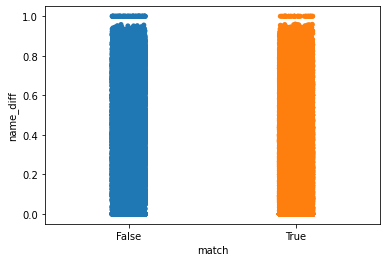

In [163]:
sns.stripplot(x="match", y="name_diff", data=pairs)
plt.show()

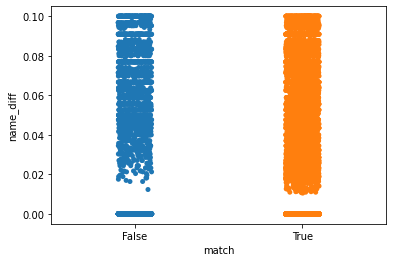

In [164]:
sns.stripplot(x="match", y="name_diff", data=pairs.loc[pairs.name_diff<0.1])
plt.show()

In [165]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff==0)&(pairs.match==False)][['name_1','name_2']]

,name_1,name_2
702,Panera Bread,Panera Bread
755,Starbucks,Starbucks
849,Wingstop,Wingstop
1071,Bank of America,Bank of America
1403,AT&T U-verse,AT&T U-verse
...,...,...
577660,Dunkin',Dunkin'
577867,Jimmy John's,Jimmy John's
578340,Starbucks,Starbucks
578407,XFINITY Store by Comcast,XFINITY Store by Comcast


### Address

In [166]:
pairs['address_diff'] = pairs.apply(sim_metric,
                          args=('address_1', 'address_2'),
                          axis=1)

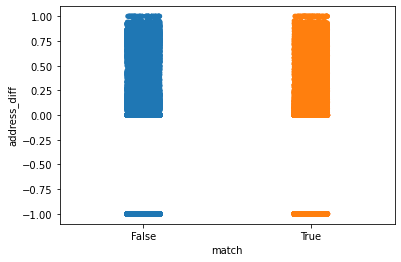

In [167]:
sns.stripplot(x="match", y="address_diff", data=pairs)
plt.show()

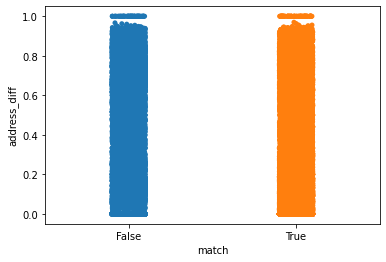

In [168]:
sns.stripplot(x="match", y="address_diff", data=pairs.loc[pairs.address_diff>=0])
plt.show()

In [169]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff<0.1)&(pairs.address_diff==0)&(pairs.match==False)&(pairs.country_1=='US')][['name_1','name_2','address_1','address_2']]

,name_1,name_2,address_1,address_2
532,Parkview High School Building H,Parkview High School Building C,"998 Cole Dr, Lilburn, GA 30047","998 Cole Dr, Lilburn, GA 30047"
2526,Sprague Lake Rest Area (Westbound),Sprague Lake Rest Area (Eastbound),Interstate 90,Interstate 90
5315,Section 304,Section 305,KeyBank Center,KeyBank Center
5316,Section 304,Section 308,KeyBank Center,KeyBank Center
6259,Facebook 1050 Building 2,Facebook 1050 Building 1,1050 Page Mill Rd,1050 Page Mill Rd
...,...,...,...,...
571522,Conference Room HS 2007,Conference Room HS 2038,Health Information and Translational Science (HS),Health Information and Translational Science (HS)
572791,Mann Center for the Performing Arts,Mann Center for the Performing Arts D Gate,5201 Parkside Ave,5201 Parkside Ave
575350,Pozez Education Center Centennial D,Pozez Education Center Centennial A,1505 SW 8th Ave,1505 SW 8th Ave
576064,UCF Business Administration II (BA2),UCF Business Administration I (BA1),4000 Central Florida Blvd,4000 Central Florida Blvd


In [170]:
pairs.match.value_counts()

True     84611
False    33097
Name: match, dtype: int64

In [171]:
pairs.loc[pairs.location_diff<1].match.value_counts()

True     83822
False    33006
Name: match, dtype: int64

### City

In [172]:
pairs['city_diff'] = pairs.apply(sim_metric,
                          args=('city_1', 'city_2'),
                          axis=1)

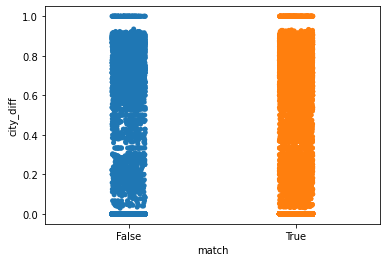

In [173]:
sns.stripplot(x="match", y="city_diff", data=pairs.loc[pairs.city_diff>=0])
plt.show()

In [174]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff<0.1)&(pairs.address_diff==0)&(pairs.city_diff==0)&(pairs.match==False)&(pairs.country_1=='US')][['name_1','name_2','address_1','address_2']]

,name_1,name_2,address_1,address_2
532,Parkview High School Building H,Parkview High School Building C,"998 Cole Dr, Lilburn, GA 30047","998 Cole Dr, Lilburn, GA 30047"
2526,Sprague Lake Rest Area (Westbound),Sprague Lake Rest Area (Eastbound),Interstate 90,Interstate 90
5315,Section 304,Section 305,KeyBank Center,KeyBank Center
5316,Section 304,Section 308,KeyBank Center,KeyBank Center
6259,Facebook 1050 Building 2,Facebook 1050 Building 1,1050 Page Mill Rd,1050 Page Mill Rd
...,...,...,...,...
571522,Conference Room HS 2007,Conference Room HS 2038,Health Information and Translational Science (HS),Health Information and Translational Science (HS)
572791,Mann Center for the Performing Arts,Mann Center for the Performing Arts D Gate,5201 Parkside Ave,5201 Parkside Ave
575350,Pozez Education Center Centennial D,Pozez Education Center Centennial A,1505 SW 8th Ave,1505 SW 8th Ave
576064,UCF Business Administration II (BA2),UCF Business Administration I (BA1),4000 Central Florida Blvd,4000 Central Florida Blvd


### State

### Zip


---

Zip codes are stored as strings in the orginal data.

In [175]:
pairs['zip_diff'] = pairs.apply(sim_metric,
                          args=('zip_1', 'zip_2'),
                          axis=1)

# PCA

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [47]:
## Make a pipeline for your PCA
pipe = Pipeline([('scale', StandardScaler()),
                    ('pca', PCA(2))])

feature_col = ['location_diff','name_diff']
#['location_diff','name_diff','address_diff', 'city_diff',	'zip_diff']

pairs_sample = pairs.loc[pairs.location_diff<1]
X_train = pairs_sample[feature_col]

pipe.fit(X_train.values)

fit = pipe.transform(X_train.values)

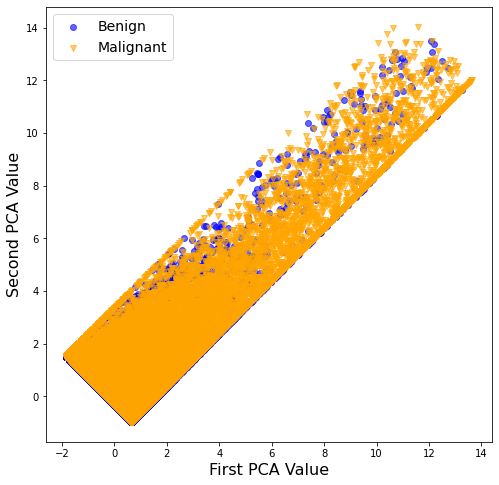

In [48]:
y_train = pairs_sample['match']

plt.figure(figsize=(8,8))

plt.scatter(fit[y_train==0, 0],
               fit[y_train==0, 1],
               c = 'b',
               alpha = .6,
               label='Benign')

plt.scatter(fit[y_train==1, 0],
               fit[y_train==1, 1],
               c = 'orange',
               marker = 'v',
               alpha = .6,
               label='Malignant')

plt.legend(fontsize=14)

plt.xlabel("First PCA Value", fontsize=16)
plt.ylabel("Second PCA Value", fontsize=16)

plt.show()

# Plotting latitude and longitude


---



In [ ]:
latitude_all = train.latitude.values
longitude_all = train.longitude.values

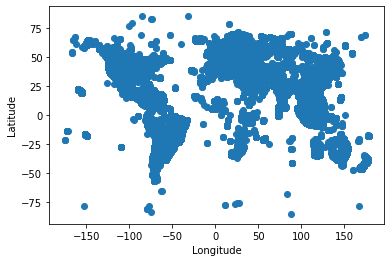

In [ ]:
plt.scatter(longitude_all, latitude_all)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
pairs.iloc[4]

id_1                              E_0000c362229d93
name_1                                  Coffee Cat
latitude_1                                7.082218
longitude_1                             125.610244
address_1                            F. Torres St.
city_1                                  Davao City
state_1                               Davao Region
zip_1                                         8000
country_1                                       PH
url_1                                          NaN
phone_1                                        NaN
categories_1                   Cafés, Coffee Shops
id_2                              E_d52c3c4d53831c
name_2                                   Coffeecat
latitude_2                                7.076016
longitude_2                             125.611457
address_2                     E. Jacinto Extension
city_2                                  Davao City
state_2                               Davao Region
zip_2                          

# Submission

---


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/sample_submission.csv')

In [ ]:
submission

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98


In [ ]:
set(test.id).intersection(set(train.id))

{'E_001b6bad66eb98', 'E_0283d9f61e569d'}

In [ ]:
df = train.loc[train.id==test.id[3]]
df.append(train.loc[train.id==test.id[4]])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
434,E_001b6bad66eb98,Foreword Communicatons,1.302216,103.861456,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_540b73568b0d3c
11033,E_0283d9f61e569d,風雲児 (Fu-unji),35.687101,139.696684,代々木2-14-3,渋谷区,東京都,151-0053,JP,http://www.fu-unji.com,0364138480,Ramen Restaurants,P_fe5531aa3acd9d


In [ ]:
test.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'],
      dtype='object')

In [ ]:
test.country

0    MY
1    US
2    RU
3    ID
4    ID
Name: country, dtype: object